##  The XYZ to sRGB function and illuminants

Wikipedia has an [article on sRGB](https://en.wikipedia.org/wiki/SRGB) that shows an algorithm for converting from an XYZ colour space to sRGB.

The code below demonstrates that and shows that the colour XYZ_to_sRGB function gives the same result.

Start by getting a colour from a colour checker space, which is in xyY space, converting to XYZ space and then comparing that conversion with my implmentation of the sRGB function.

There are a number of colour checkers that could be used but I am going to use "ColorChecker 1976" as I have a 2005 Greta Macbeth mini color checker that uses this scheme according to the colour specification that was supplied with it.  This will be shown to be a bad choice.

Note that this function renders the purple as #5e3a6d

Table of results of ColourChecker 1976 with illuminant in which I ignored first time around:

Function|Colour | Illuminant
--------|-----|---
plot_single_colour_checker|#5E396D | C implicit
xyY_to_XYZ & XYZ_to_sRGB | #5F3871| D65 implicit
Wikipedia own function |#5F3871| D65 explicit
XYZ_to_plotting_colourspace | #5A3982 | D50 explicit 
XYZ_to_plotting_colourspace |  #5F3871 | D65 explicit
XYZ_to_plotting_colourspace |  #5E396D | C explicit

## Illiuminant affects final value
This is nicely shown with the function XYZ_to_plotting_colourspace and the table above.  The C illuminant is now considered obsolete as against the more standardised D65 or D50 illuminants

## Confusion in sRGB standard

The sRGB standard expects colour encoding to be done with a D65 illuminant but then to be viewed on a monitor with a dim D50 light.  So I am a little confused about this.  If you encode the colour values of a colour checker with a D65 illuminant then colours on screen will not match the same colour checker when placed next to the screen with a D50 illuminant.

I suppose the only way to test this is to take some pictures experimentally.

## Why ColourChecker 1976 is the wrong choice

This is not a good choice as the illuminant used in the paper doesn't match the sRGB standard whereas the standard illuminant for all the saples does.  See the next section on the differences between different colours with 2005 taken as a reference:

###  How the xyY value of  purple varies
Transform | xyY value | ∆E₀₀
-----|-----|----
ColorChecker 1976  |                      [ 0.2845  0.202   0.0656]             |   7.21
ColorChecker 2005   |                     [ 0.3319  0.2482  0.0637]             |   0.00
BabelColor Average   |                    [ 0.3326  0.2556  0.0644]             |   1.17
ColorChecker24 - Before November 2014   | [ 0.33191051  0.24828597  0.06369016] |   0.01
ColorChecker24 - After November 2014    | [ 0.33347115  0.2505523   0.06276663] |   0.43

This shows that the 1976 values are more different and it would have better to use a ColourChecker 2005 as a base.


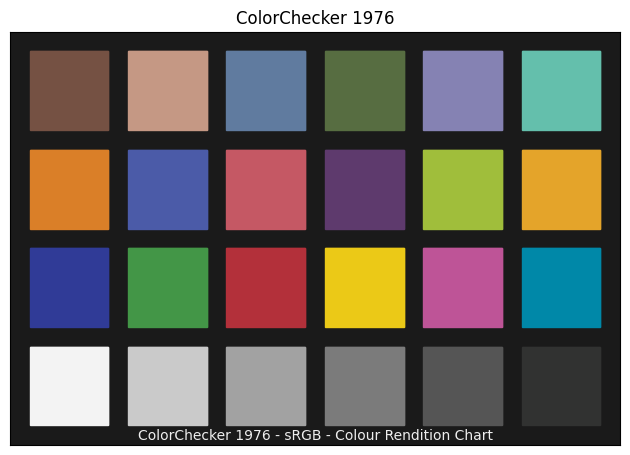

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'ColorChecker 1976'}>)

In [1]:
%pip install -q colour-science
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import colour
import colour.plotting as cp 
CHECKER_VERSION = "ColorChecker 1976"
cp.plot_single_colour_checker(CHECKER_VERSION, text_kwargs={"visible": False} )

# Get one data point (purple) and convert to different colour spaces
The data is xyY space.  However most of the conversion routines are in XYZ space



In xyY space this is purple (p): [ 0.2845  0.202   0.0656]
In XYZ space this is purple (p1): [ 0.09239208  0.0656      0.1667604 ]
to Lab (p2): [ 30.78348847  28.24630135 -26.33722483]
XYZ to sRGB default (p3): [ 0.37407601  0.22221792  0.44676055] hex #5F3871


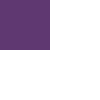

In [2]:
def rgb_to_hex(c):
    c1 = c*255
    c2 = f"#{int(c1[0]):02X}{int(c1[1]):02X}{int(c1[2]):02X}"
    return c2
cc = colour.characterisation.datasets.colour_checkers.CCS_COLOURCHECKERS

%pip install "drawsvg~=2.0"
import drawsvg as draw
def swatch(RGB):
    d = draw.Drawing(100, 100, origin='center')
    # Draw a rectangle
    r = draw.Rectangle(-50, -50, 50, 50, fill=rgb_to_hex(RGB))
    d.append(r)
    return d
    
p = cc[CHECKER_VERSION].data["purple"]
print(f"In xyY space this is purple (p): {p}")
p1 = colour.xyY_to_XYZ(p)
print(f"In XYZ space this is purple (p1): {p1}")
p2 = colour.XYZ_to_Lab(p1)
print(f"to Lab (p2): {p2}")
p3 = colour.XYZ_to_sRGB(p1)
print(f"XYZ to sRGB default (p3): {p3} hex {rgb_to_hex(p3)}")
swatch(p3)

Note that this method of drawing the swatch the colour matches #5f3871 the input colour.  This shows that the colour swatch method used by colour has a different rendering intent, different illuminant or something.  The colour difference is TBC 

The main conversion function is shown below from the Wikipedia page and I have also implemented the gamma function.

$$
{\displaystyle {\begin{bmatrix}R_{\text{linear}}\\G_{\text{linear}}\\B_{\text{linear}}\end{bmatrix}}={\begin{bmatrix}+3.2406&-1.5372&-0.4986\\-0.9689&+1.8758&+0.0415\\+0.0557&-0.2040&+1.0570\end{bmatrix}}{\begin{bmatrix}X_{D65}\\Y_{D65}\\Z_{D65}\end{bmatrix}}}
$$

to sRGB own function (p4): [0.3740760061089989 0.22221792497451975 0.44676055375148577] #5F3871
p4 == p3: [ True  True  True]


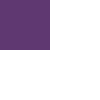

In [3]:
# Conversion matrix to linear RGB
sx = np.array([
    [+3.2406,-1.5372,-0.4986],
    [-0.9689,+1.8758,+0.0415],
    [+0.0557,-0.2040,+1.0570]])
# sRGB gamma function in linear RGB space
def gamma(l):
    if l <= 0.0031308:
        return 12.92 * l
    return (1.055* l ** (1/2.4))-0.055
# print(255*gamma(0.0031307),255*gamma(0.0031308),255*gamma(0.0031309))
# sRGB gamma function as a numpy function
ngamma = np.frompyfunc(gamma, 1, 1)
# Converting XYZ value above to sRGB
p4 = ngamma(sx @ p1)
print(f"to sRGB own function (p4): {p4} {rgb_to_hex(p4)}")
print(f"p4 == p3: {p4==p3}")
swatch(p4)

So this is proof that my conversion and the calculation are the same.  However there is still the difference of the swatch rending which may be due to a different illiumination.

In the formula this refers to D65 data and I thought the sRGB used a D50 illuminant.

Wikipedia says:

```
The sRGB specification assumes a dimly lit encoding (creation) environment with an ambient correlated color temperature (CCT) of 5003 K. This differs from the CCT of the illuminant (D65). Using D50 for both would have made the white point of most photographic paper appear excessively blue.[8][9] The other parameters, such as the luminance level, are representative of a typical CRT monitor.```

Following the code in github https://github.com/colour-science/colour

plot_single_colour_checker calls plot_multi_colour_checkers which allows colour checks to be compared.

The conversion code is 
XYZ = xyY_to_XYZ(xyY)  # seems ok
RGB = XYZ_to_plotting_colourspace(XYZ, colour_checker.illuminant) # different
## Checking illuminants in the colourChecker array

    colour_swatches.append(
        ColourSwatch(np.clip(np.ravel(RGB), 0, 1), label.title())
    )

In [4]:
[[cc[ck].name,cc[ck].illuminant] for ck in cc.keys()]

[['ColorChecker 1976', array([ 0.31006,  0.31616])],
 ['ColorChecker 2005', array([ 0.34570291,  0.3585386 ])],
 ['BabelColor Average', array([ 0.34570291,  0.3585386 ])],
 ['ColorChecker24 - Before November 2014', array([ 0.34570291,  0.3585386 ])],
 ['ColorChecker24 - After November 2014', array([ 0.34570291,  0.3585386 ])],
 ['BabelColor Average', array([ 0.34570291,  0.3585386 ])],
 ['ColorChecker 2005', array([ 0.34570291,  0.3585386 ])],
 ['ColorChecker24 - Before November 2014', array([ 0.34570291,  0.3585386 ])],
 ['ColorChecker24 - After November 2014', array([ 0.34570291,  0.3585386 ])]]

as xy x = 0.3127, y = 0.3290 (D65)
Image surround reflectance 	20% (~medium gray)
Encoding ambient illuminance level 	64 lux
Encoding ambient white point 	x = 0.3457, y = 0.3585 (D50)

In [5]:
D50= np.array([0.3457, 0.3585])
ils = [["D50", 0.3457, 0.3585],["D65",0.3127,0.3290],["cc1976", 0.31006,  0.31616]]

In [6]:
rgb_to_hex(cp.XYZ_to_plotting_colourspace(p1,D50))

'#5A3982'

In [7]:
for il in ils:
    rgb = cp.XYZ_to_plotting_colourspace(p1,np.array([il[1],il[2]]))
    hex = rgb_to_hex(rgb) 
    print(f"{il[0]} {hex}")
    swatch(rgb)

D50 #5A3982
D65 #5F3871
cc1976 #5E396D


Wikipedia has a good table about [colour temperature white points](https://en.wikipedia.org/wiki/Template:Color_temperature_white_points)  which I have extracted some data here:

The illuminant in the 1976 colourchecker is the obsolete C which leads

|Illuminant Name | x | y | CCT | Comment |
|----------------|---|---|--|-------|
| C              |0.31006 |0.31616| 6774 | Obsolete used in 1976 paper |
| D50            |0.3457|  0.3585| 5003 | Light for viewing sRGB images|
| D65            |0.3127 | 0.3290 |6504 | Illuminant assumed sRGB |


## Comparing plots ColorChecker 1976 and ColorChecker 2005
This plots each swatch as three horizontal stripes the outside are the first colour checker and the middle is the second note the purple varies but I can't see the difference.

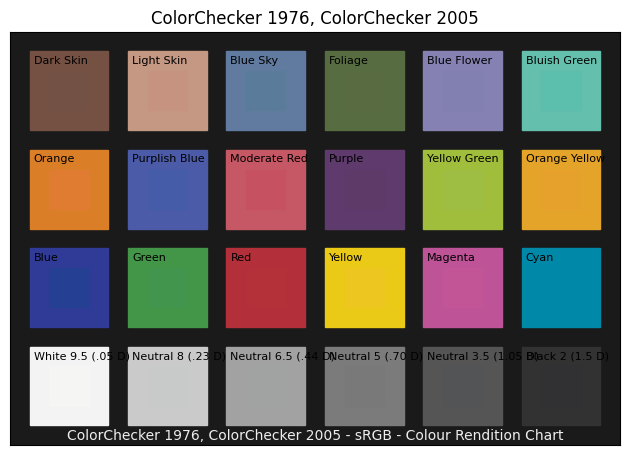

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'ColorChecker 1976, ColorChecker 2005'}>)

In [8]:
cp.plot_multi_colour_checkers(["ColorChecker 1976", "ColorChecker 2005"])

## Variation of purple in xyy Space
This is just meant to show the variation in the underlying purple for the different colour variations over time.

ColorChecker24 - Before November 2014 is essentially the same as ColourChecker 2005 (with more precision) but the 1976 colours are quite differrent.

In [9]:
def xyY_to_Lab(xyY):
    XYZ = colour.xyY_to_XYZ(xyY)
    Lab = colour.XYZ_to_Lab(XYZ)
    return Lab

def de(xyY, ref):
    lab = xyY_to_Lab(xyY)
    d = colour.difference.delta_E_CIE2000(ref, lab)
    return d

In [10]:
a = [[cc[ck].name,cc[ck].data["purple"]] for ck in cc.keys()]
ref = xyY_to_Lab(cc["ColorChecker 2005"].data["purple"])
for b in a[:-4]:
    s = f"{b[1]}"
    print(f"{b[0]:40} {s:40} {de(b[1], ref):0.2f}")

ColorChecker 1976                        [ 0.2845  0.202   0.0656]                7.21
ColorChecker 2005                        [ 0.3319  0.2482  0.0637]                0.00
BabelColor Average                       [ 0.3326  0.2556  0.0644]                1.17
ColorChecker24 - Before November 2014    [ 0.33191051  0.24828597  0.06369016]    0.01
ColorChecker24 - After November 2014     [ 0.33347115  0.2505523   0.06276663]    0.43


# Table of differences
The results above are for a single colour, so if you look at all the colour differences what results do you get.
I also want to put a correction in for the different illuminant used in 1976.  I don't have enough data so need to use an approcimation by converting to sRGB and back.

In [11]:
D65 = colour.CCS_ILLUMINANTS["CIE 1931 2 Degree Standard Observer"]["D65"]
D50 = colour.CCS_ILLUMINANTS["CIE 1931 2 Degree Standard Observer"]["D50"]
C = colour.CCS_ILLUMINANTS["CIE 1931 2 Degree Standard Observer"]["C"]
colours = list(cc[CHECKER_VERSION].data.keys())
examples = list(cc.keys())[:5]
colnames = ["CC1976","CC2005","Babel","CC24","CC2014"]
print("Table of column names")
for i, full in enumerate(examples):
    print(f"{colnames[i]:6} {full}")
print("\nColour                   ", end = "")
for name in colnames:
    print(f"{name:10}",end="")
print(f"76C->D65", end="")
print()
for mycolour in colours:
    print(f"{mycolour[:20]:20}",end = "")
    a = [[cc[ck].name,cc[ck].data[mycolour]] for ck in cc.keys()]
    ref = xyY_to_Lab(cc["ColorChecker 2005"].data[mycolour])
    for b in a[:-4]:
        print(f"{de(b[1], ref):10.2f}", end="")
    aXYZ = colour.xyY_to_XYZ(cc["ColorChecker 1976"].data[mycolour])
    bXYZ = colour.chromatic_adaptation(aXYZ, colour.xy_to_XYZ(C), colour.xy_to_XYZ(D65))
    bLab = colour.XYZ_to_Lab(bXYZ)
    d = colour.difference.delta_E_CIE2000(ref, bLab)
    print(f"{d:10.2f}", end="")
    print()

Table of column names
CC1976 ColorChecker 1976
CC2005 ColorChecker 2005
Babel  BabelColor Average
CC24   ColorChecker24 - Before November 2014
CC2014 ColorChecker24 - After November 2014

Colour                   CC1976    CC2005    Babel     CC24      CC2014    76C->D65
dark skin                 5.82      0.00      0.49      0.01      0.67      3.76
light skin                8.61      0.00      0.27      0.01      1.24      5.95
blue sky                 10.11      0.00      0.54      0.03      1.51      7.74
foliage                   5.51      0.00      0.16      0.01      0.60      5.53
blue flower               9.72      0.00      0.56      0.01      0.89      8.17
bluish green             10.41      0.00      0.18      0.01      0.51      7.37
orange                    2.78      0.00      0.58      0.01      0.15      3.76
purplish blue             4.44      0.00      0.61      0.01      0.78      3.47
moderate red              6.81      0.00      0.65      0.00      0.58      5.19

## Conclusion on 1976
The colour checkers after 2005 are roughly congruent.  The 1976 data with C illuminant seems different and not easily transformed.